In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [2]:
import yfinance as yf

In [3]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real RELIANCE Stock Price')
    plt.plot(predicted, color='blue',label='Predicted RELIANCE Stock Price')
    plt.title('RELIANCE Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('RELIANCE Stock Price')
    plt.legend()
    plt.show()

In [4]:
#see the yahoo finance ticker for your stock symbol
stock_symbol = "RELIANCE.NS"

In [5]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol, period='5y', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-30,972.779053,983.279480,950.985596,954.254639,933.830017,8955897
2018-05-02,957.919861,970.005310,955.988159,963.566345,942.942383,6175751
2018-05-03,968.717529,968.717529,950.242676,952.570557,932.181946,3984964
2018-05-04,953.808838,955.641479,941.079529,944.992432,924.766052,3831671
2018-05-07,949.846375,964.111206,947.369873,961.882324,941.294373,3545827


In [7]:
# Checking for missing values
training_set = data[:'2022-04'].iloc[:,1:2].values
test_set = data['2022-04':].iloc[:,1:2].values

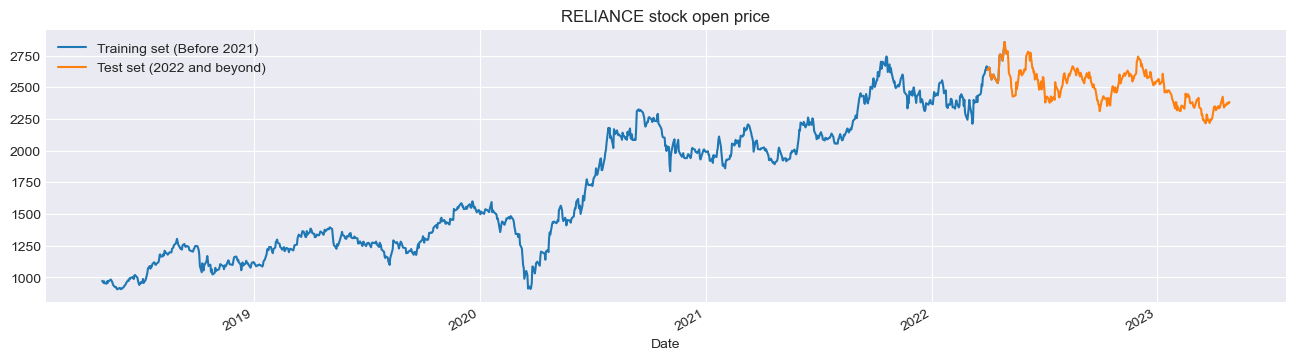

In [8]:
# We have chosen 'Open' attribute for prices. Let's see what it looks like
data["Open"][:'2022-04'].plot(figsize=(16,4),legend=True)
data["Open"]['2022-04':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2021)','Test set (2022 and beyond)'])
plt.title('RELIANCE stock open price')
plt.show()

In [9]:
opn = data[['Open']]

<AxesSubplot:xlabel='Date'>

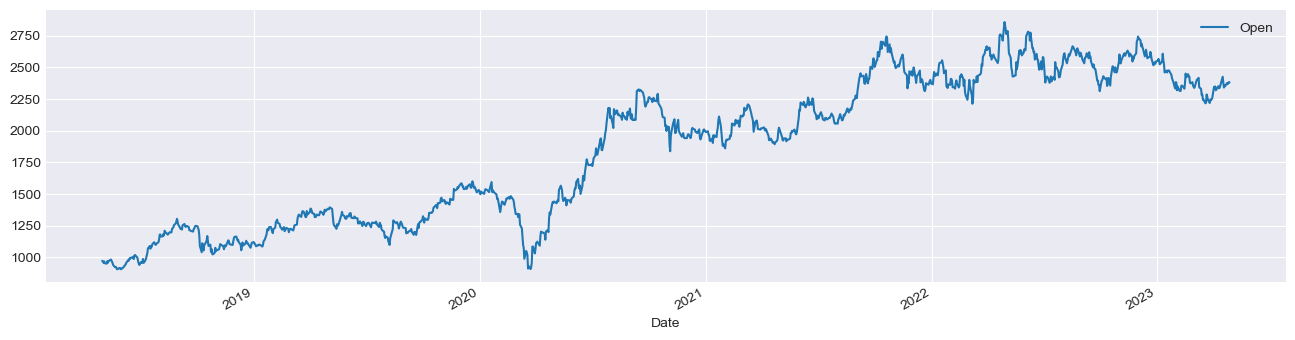

In [10]:
opn.plot(figsize=(16,4),legend=True)

In [11]:
ds = opn.values

In [12]:
ds

array([[ 972.77905273],
       [ 957.91986084],
       [ 968.7175293 ],
       ...,
       [2379.        ],
       [2375.        ],
       [2382.        ]])

In [13]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [14]:
len(ds_scaled), len(ds)

(1235, 1235)

In [15]:
#Defining test and train data sizes
train_size = int(len(data[:'2022-04']))
test_size = int(len(data['2022-04':]))

In [16]:
train_size, test_size

(988, 266)

In [17]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [18]:
len(ds_train), len(ds_test)

(988, 247)

In [19]:
#Creating dataset in time series for BiLSTM model
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset, step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [20]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, Y_train = create_ds(ds_train, time_stamp)
X_test, Y_test = create_ds(ds_test, time_stamp)

In [21]:
X_train.shape, Y_train.shape

((887, 100), (887,))

In [22]:
X_test.shape, Y_test.shape

((146, 100), (146,))

In [23]:
#Reshaping data to fit into BiLSTM model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
#Creating BiLSTM model using keras
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh')))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh')))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh')))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, activation='tanh')))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [25]:
model.compile(loss='mean_squared_error', optimizer='SGD')
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=8)
model.evaluate(X_train, Y_train)
print(history.history['loss'])

Epoch 1/100
111/111 [==============================] - 31s 175ms/step - loss: 0.0622 - val_loss: 0.0618
Epoch 2/100
111/111 [==============================] - 17s 154ms/step - loss: 0.0292 - val_loss: 0.0161
Epoch 3/100
111/111 [==============================] - 17s 156ms/step - loss: 0.0136 - val_loss: 0.0036
Epoch 4/100
111/111 [==============================] - 17s 157ms/step - loss: 0.0090 - val_loss: 0.0041
Epoch 5/100
111/111 [==============================] - 18s 159ms/step - loss: 0.0076 - val_loss: 0.0040
Epoch 6/100
111/111 [==============================] - 18s 160ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 7/100
111/111 [==============================] - 18s 161ms/step - loss: 0.0067 - val_loss: 0.0038
Epoch 8/100
111/111 [==============================] - 18s 161ms/step - loss: 0.0064 - val_loss: 0.0026
Epoch 9/100
111/111 [==============================] - 18s 162ms/step - loss: 0.0059 - val_loss: 0.0042
Epoch 10/100
111/111 [==============================] - 18s 162m

111/111 [==============================] - 19s 173ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 80/100
111/111 [==============================] - 19s 174ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 81/100
111/111 [==============================] - 19s 173ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 82/100
111/111 [==============================] - 19s 173ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 83/100
111/111 [==============================] - 19s 173ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 84/100
111/111 [==============================] - 19s 173ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 85/100
111/111 [==============================] - 19s 174ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 86/100
111/111 [==============================] - 19s 175ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 87/100
111/111 [==============================] - 19s 173ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 88/100
111/111 [==============================] - 19s 173ms/st

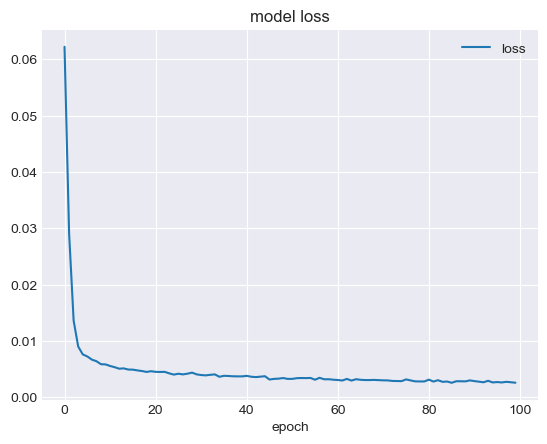

In [26]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper right')
plt.show()

In [27]:
#Predicting on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5/5 [==============================] - 0s 57ms/step


In [28]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

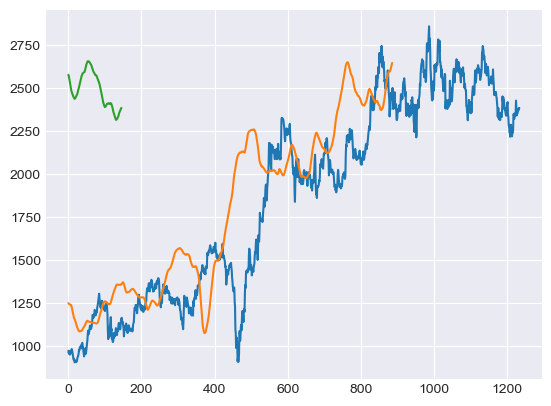

In [29]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [30]:
test = np.vstack((train_predict, test_predict))

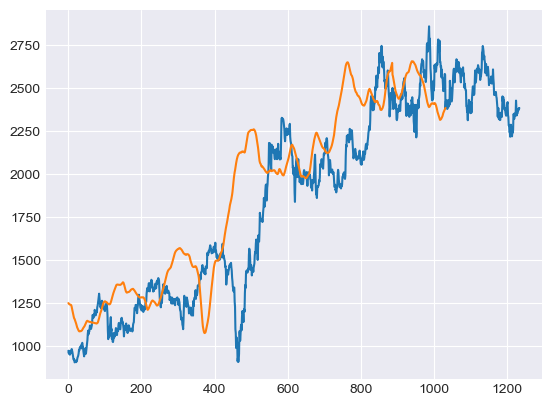

In [31]:
#combining the predicted data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [32]:
len(ds_test)

247

In [33]:
#Getting last 100 days records
fut_inp = ds_test[147:]

In [34]:
fut_inp = fut_inp.reshape(1,-1)

In [35]:
tmp_inp = list(fut_inp)

In [36]:
fut_inp.shape

(1, 100)

In [37]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [38]:
#Predicting next 30 days price using the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp = fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i = i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i+1
        
        
print(lst_output)

[[0.7613554000854492], [0.7634482383728027], [0.765516459941864], [0.7675695419311523], [0.7695958018302917], [0.7716044187545776], [0.7735910415649414], [0.7755653858184814], [0.7775121927261353], [0.7794326543807983]]


In [39]:
len(ds_scaled)

1235

In [40]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,111)

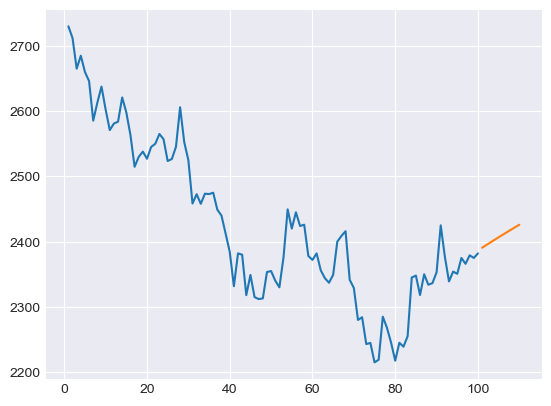

In [41]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1135:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [42]:
ds_new = ds_scaled.tolist()

In [43]:
len(ds_new)

1235

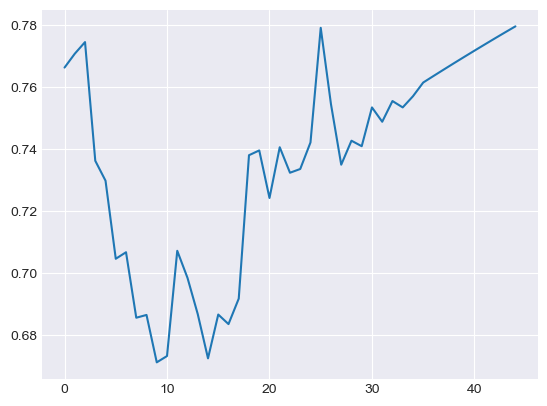

In [44]:
#Extends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [45]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

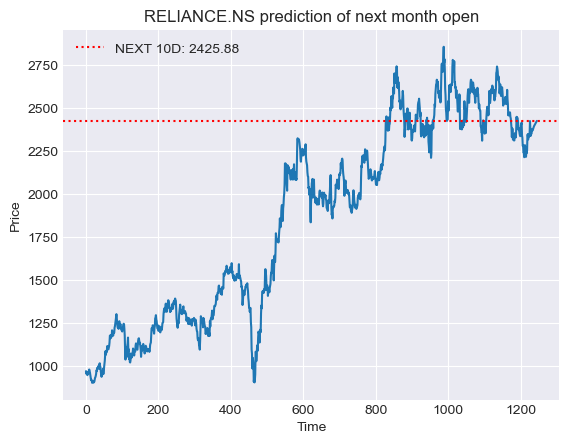

In [46]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 10D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()